In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
import dask

In [ ]:
from estimator import RFClassifier, relu, bp_weights_dft, random_feature_matrix, bp_weights_gaus
from data_fns import pure_sine_dft

In [ ]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

In [ ]:
# data
fs = 1000
t = np.arange(0, 1, 1/fs)
A = scipy.linalg.dft(fs, scale=None)
x = A[:, 5].real + np.random.normal(0, 0.1, fs)
x_noise = np.random.normal(0, 1, fs)

fig = plt.figure(figsize=(12, 8))
plt.plot(t, x_noise, 'k')
plt.plot(t, x, 'r')
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
# plt.savefig('figures/lab_meeting/signal_noise.png')

In [ ]:
# traditional random features
M, N = 5, fs
random_weights = random_feature_matrix(M, N, 'white noise').T
bp_weights = bp_weights_dft(M, N, 1, 5).T

In [ ]:
i = np.random.randint(M)
fig = plt.figure(figsize=(12, 5))
ax  = fig.add_subplot(121)
plt.plot(t, random_weights[i], 'b')

ax = fig.add_subplot(122)
plt.plot(t, bp_weights[i], '--b')
plt.plot(t, bp_weights[i - 1], '--b')
plt.savefig('figures/lab_meeting/feature_examples.png')

In [ ]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

In [ ]:
# generate data
nPoints, fs, sig_dur = 5000, 1500, 0.1
k, a = 5, 0.8
X, y = pure_sine_dft(nPoints, fs, k, sig_dur, a, seed=20)

N = X.shape[1]
f_signal = int(k / sig_dur)
print('signal frequency=%d Hz' % f_signal)

# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

In [ ]:
%%time
# classification
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k + 2, highcut=k + 5)
h = relu

weights = [('bandpass_dft', f_gaus), ('white noise', None)]
results = {wt:[] for (wt, func) in weights}
for n in n_features:
    for (wt, func) in weights:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))

In [ ]:
mean_err_bp, std_err_bp = np.mean(results['bandpass_dft'], axis=1), np.std(results['bandpass_dft'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_bp, yerr=std_err_bp, fmt='-', label='Bandpassed',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='White noise',  
            markersize=4, lw=3)
# ax.set_yscale('log')
plt.xlim([0, 200])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=16)
plt.savefig('figures/lab_meeting/empirical_results_a=%0.2f.png' % a)

In [ ]:
# dft coef
dft = scipy.linalg.dft(N)
X_pos = X_train[y_train == 1]
X_neg = X_train[y_train == -1]

dft_positive = X_pos @ dft
dft_negative = X_neg @ dft

fig = plt.figure(figsize=(8,6))
plt.title('DFT coefficients at signal frequency (%d Hz)' % f_signal, fontsize=16)
plt.scatter(dft_positive[:, k].real, dft_positive[:, k].imag, marker='o', c='r')
plt.scatter(dft_negative[:, k].real, dft_negative[:, k].imag, marker='o', c='k')
plt.xlabel('Real dft coefficient', fontsize=16)
plt.ylabel('Imag dft coefficient', fontsize=16)
plt.savefig('figures/lab_meeting/dft_coef_signal_frequency.png')

i=8
fig = plt.figure(figsize=(8,6 ))
plt.title('DFT coefficients at other frequencies (80 Hz)', fontsize=16)
plt.scatter(dft_positive[:, i].real, dft_positive[:, i].imag, marker='o', c='r')
plt.scatter(dft_negative[:, i].real, dft_negative[:, i].imag, marker='o', c='k')
plt.xlabel('Real dft coefficient', fontsize=16)
plt.ylabel('Imag dft coefficient', fontsize=16)
plt.savefig('figures/lab_meeting/dft_coef_non_signal_frequency.png')

In [ ]:
coef_positive = np.mean(np.abs(dft_positive), axis=0)
coef_negative = np.mean(np.abs(dft_negative), axis=0)

fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(N) / sig_dur, coef_positive, 'r', label='signal')
plt.plot(np.arange(N) / sig_dur, coef_negative, 'k', label='noise')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Power', fontsize=16)
plt.legend(fontsize=16)
plt.savefig('figures/lab_meeting/frequency_power.png')

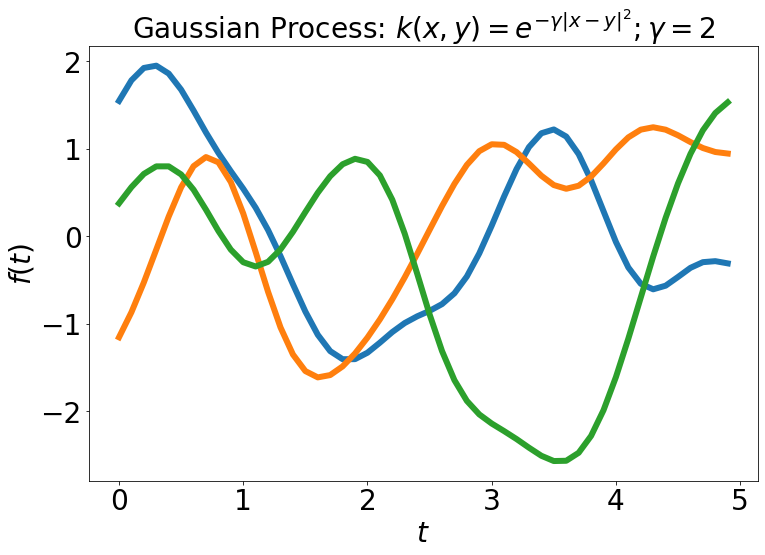

In [52]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# sampling a gaussian process
gamma = 2
t = np.arange(0, 5, 0.1).reshape(-1, 1)
K = squareform(pdist(t, 'sqeuclidean'))
K = np.exp(- gamma * K )

# cholesky
L = np.linalg.cholesky(K + 1e-15*np.eye(len(t)))

# generate a sequence of normal variables
eta = np.random.standard_normal(size=(len(t), 3))

gp = np.dot(L, eta)

# plot
fig = plt.figure(figsize=(12, 8))
plt.title(r'Gaussian Process: $k(x, y) = e^{-\gamma \|x - y \|^2}; \gamma=%d$' % gamma, fontsize=28)
plt.plot(t, gp, lw=6)
plt.xlabel(r'$t$', fontsize=28)
plt.ylabel(r'$f(t)$', fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('figures/lab_meeting/gaussian_process.png')

In [42]:
ls figures/lab_meeting/

dft_coef_non_signal_frequency.png            empirical_results.png
dft_coef_signal_frequency.png                feature_examples.png
empirical_results_a=0.70.png                 frequency_power.png
empirical_results_a=0.80.png                 signal_noise.png
empirical_results_a=0.80_wrong_features.png


In [ ]:
L.shape